## Move Count

A plan which will move N motors from position A to position B with velocity V (specified for each motor)

RE(mov_count([det1,det2],motor1, start_pos_1, stop_pos_1, vel_1, motor_2, start_pos_2, stop_pos2, vel_2))

In [22]:
# Define test environment
from databroker.v2 import temp
from bluesky.plans import count
from bluesky import RunEngine
from bluesky.callbacks.best_effort import BestEffortCallback

RE = RunEngine({})
db = temp()
RE.subscribe(db.v1.insert)

bec = BestEffortCallback()
RE.subscribe(bec)

# create connection to simulated epics motor record

from ophyd import EpicsMotor

"""
SISSY2EX:MotorSim:m1
SISSY2EX:MotorSim:m2
SISSY2EX:MotorSim:m3
SISSY2EX:MotorSim:m4
SISSY2EX:MotorSim:m5
SISSY2EX:MotorSim:m6
SISSY2EX:MotorSim:m7
SISSY2EX:MotorSim:m8

"""

motor1 = EpicsMotor("SISSY2EX:MotorSim:m1", name= "motor1")
motor2 = EpicsMotor("SISSY2EX:MotorSim:m2", name= "motor2")

from ophyd.sim import noisy_det



In [7]:
motor1.velocity.set(1)

motor1.move(0)

MoveStatus(done=True, pos=motor1, elapsed=10.3, success=True, settle_time=0.0)



Transient Scan ID: 1     Time: 2023-04-17 15:25:36
Persistent Unique Scan ID: '65c6cd33-c5c0-474a-980b-6c7a0241bbb5'
New stream: 'primary'
+-----------+------------+------------+------------+------------+
|   seq_num |       time |     motor1 |     motor2 |  noisy_det |
+-----------+------------+------------+------------+------------+
|         1 | 15:25:39.0 |    0.00000 |    0.00000 |      0.905 |
|         2 | 15:25:39.6 |    0.33000 |    0.33000 |      0.917 |
|         3 | 15:25:40.2 |    0.67000 |    0.67000 |      1.040 |
|         4 | 15:25:40.8 |    1.00000 |    1.00000 |      1.056 |
+-----------+------------+------------+------------+------------+
generator scan ['65c6cd33'] (scan num: 1)





('65c6cd33-c5c0-474a-980b-6c7a0241bbb5',)

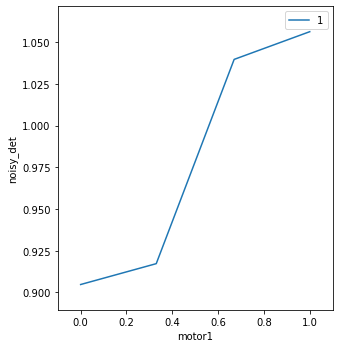

In [23]:
from bluesky.plans import scan

RE(scan([noisy_det], motor1, 0,1,motor2, 0,1,4))


In [24]:
# Move Count

from bluesky import plan_stubs as bps
from bluesky import preprocessors as bpp
from functools import partial
import numpy as np

from itertools import chain, zip_longest
from functools import partial
import collections
from collections import defaultdict
import time

import numpy as np
from toolz import partition


from bluesky.utils import (
    separate_devices,
    all_safe_rewind,
    Msg,
    ensure_generator,
    short_uid as _short_uid,
)

from ophyd import Signal

def mov_count(detectors,motor1, start_pos_1, stop_pos_1,motor_2, start_pos_2, stop_pos_2,delay=0, md=None):
    """
    read from detectors in a list while 2 motors are moving. Stop only when they complete

    Parameters
    ----------
    detectors : list
        list of 'readable' objects
    motor1 : positioner
    start_pos_1 : float
    stop_pos_1 : float
    motor2 : positioner
    start_pos_2 : float
    stop_pos_2 : float
    delay : iterable or scalar, optional
        Time delay in seconds between successive readings; default is 0.2
    md : dict, optional
        metadata

    Notes
    -----

    """

    motors_list = [motor1, motor2]


    #Define the motor metadata (important for plotting)
    md = md or {}
    x_fields = []
    for motor in motors_list:
        x_fields.extend(getattr(motor, 'hints', {}).get('fields', []))

    _md = {'detectors': [det.name for det in detectors],
           'plan_args': {'detectors': list(map(repr, detectors)),
                         'motors': list(map(repr,motors_list))
                        },
           'plan_name': 'mov_count',
           'hints': {}
           }

    _md.update(md or {})

    # Deterime the name of the x axis for plotting from the flyer
    default_dimensions = [(x_fields, 'primary')]
    default_hints = {}
    
    # The following is left from the scan plan implementation, assumes multiple motors
    if len(x_fields) > 0:
        default_hints.update(dimensions=default_dimensions)
    
    # now add default_hints and override any hints from the original md (if
    # exists)
    
    _md['hints'] = default_hints
    _md.update(md)

    #Add the flyer to the list of things we want to count
    detectors_list = detectors + motors_list
    
    # Init the run
    uid = yield from bps.open_run(_md)

    # Start the motors and wait until it's reported that it's done
    yield from bps.mov(motor1,start_pos_1, motor2, start_pos_2, group="start_move")
    yield from bps.wait("start_move")    

    # Get the status object that tells us when it's done
    complete_status1 = yield Msg('set', motor1, stop_pos_1)
    complete_status2 = yield Msg('set', motor2, stop_pos_2)

    while not complete_status1.done or not complete_status2.done:

        yield Msg('checkpoint') # allows us to pause the run 
        yield from bps.one_shot(detectors_list) #triggers and reads everything in the detectors list
        yield Msg('sleep', None, delay)

    
    yield from bps.close_run()
    return uid

    






Transient Scan ID: 2     Time: 2023-04-17 15:25:48
Persistent Unique Scan ID: '3b717e62-3e54-45b7-acc6-7d74f3c37cd7'
New stream: 'primary'
+-----------+------------+------------+------------+------------+
|   seq_num |       time |     motor1 |     motor2 |  noisy_det |
+-----------+------------+------------+------------+------------+
|         1 | 15:25:49.4 |    0.00000 |    1.00000 |      1.079 |
|         2 | 15:25:49.5 |    0.09000 |    1.09000 |      1.010 |
|         3 | 15:25:49.6 |    0.19000 |    1.19000 |      0.955 |
|         4 | 15:25:49.8 |    0.29000 |    1.29000 |      1.063 |
|         5 | 15:25:49.9 |    0.39000 |    1.39000 |      0.974 |
|         6 | 15:25:50.0 |    0.59000 |    1.59000 |      0.902 |
|         7 | 15:25:50.1 |    0.69000 |    1.69000 |      0.961 |
|         8 | 15:25:50.3 |    0.79000 |    1.79000 |      0.933 |
|         9 | 15:25:50.4 |    0.97000 |    1.97000 |      1.064 |
|        10 | 15:25:50.5 |    1.00000 |    2.00000 |      0.911 |
+

('3b717e62-3e54-45b7-acc6-7d74f3c37cd7',)

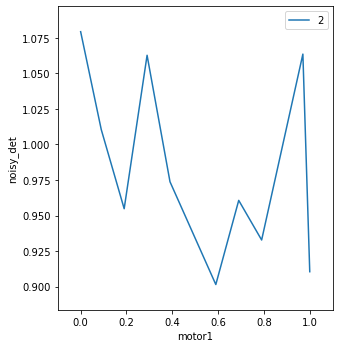

In [25]:
plan = mov_count([noisy_det],motor1,0,1,motor2, 1,2,delay=0.1)

RE(plan)